# Predicting NYC Cab Trip Durations

The goal of this challenge is to predict taxi cab trip durations in NYC given some historical data. This notebook will outline a principled approach to building a machine learning model in the context of this challenge.

We will **not** be using external data sources such as the OSRM distance data, weather data, etc. All feature selection and feature engineering will be performed on the raw supplied data.

I have decided to test two tree-based algorithms - the infamous `XGBoost`, and the slightly less talked about `CatBoost`. We're aiming to break the 0.4 barrier on the public Kaggle test set.

The notebook is organized into 4 sections:

 1. [Exploratory Analysis and Feature Engineering](#eafe)  
  1.1 [Missing Data](#missingdata)  
  1.2 [Target Variable Distribution](#tvd)  
  1.3 [Categorical Data](#catdata)  
  1.4 [`datetime` Data](#dtdata)  
  1.5 [Feature Correlation](#featcor)  
  1.6 [Geospatial Clustering](#clustering)
 2. [Modeling and Cross Validation](#Modeling)  
  2.1 [XGBoost](#XGBoost)  
  2.2 [CatBoost](#CatBoost)
 3. [Submission](#Submission)
 4. [Discussion](#Discussion)

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import xgboost as xgb

from catboost import CatBoostRegressor, Pool
from catboost import cv as catboost_cv
from IPython.display import display

from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
print(os.listdir('./input'))

['test.csv', 'train.csv']


In [3]:
%matplotlib inline

In [65]:
DO_XGBOOST = True
DO_CATBOOST = not DO_XGBOOST

<a id="eafe"></a>

## Exploratory Analysis, Feature Engineering

In [4]:
train_raw = pd.read_csv('./input/train.csv', index_col='id', 
                        parse_dates=['pickup_datetime', 'dropoff_datetime'])
test_raw = pd.read_csv('./input/test.csv', index_col='id', 
                       parse_dates=['pickup_datetime'])

Let's begin by taking a look at the data that is made available to us in both the train and test sets.

*Yes, Kaggle tells us what columns are in the `.csv` files, but let's be explicit.*

In [69]:
print('Train set:\n')
train_raw.info()

Train set:

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 122.4+ MB


In [70]:
print('Test set:\n')
test_raw.info()

Test set:

<class 'pandas.core.frame.DataFrame'>
Index: 625134 entries, id3004672 to id0621643
Data columns (total 8 columns):
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 42.9+ MB


Our target variable is the `trip_duration` column in the **train** set. Keep in mind that the supplied **test** set does **not** have the `trip_duration` column (logical, as this column is what the models are scored on in the Kaggle competition). Likewise, the `dropoff_datetime` is only available to us in the train set.

So, it seems our common data between the train and test sets are:
- `vendor_id`
- `pickup_datetime`
- `passenger_count`
- `pickup_longitude`
- `pickup_latitude`
- `dropoff_longitude`
- `dropoff_latitude`
- `store_and_fwd_flag`

<a id="missingdata"></a>

### Missing Data

A good place to start is making sure that we don't have any missing data - either empty columns, NaN values, or "hidden" missing data (data which is present in the columns, but doesn't correspond to any tangible information)

In [78]:
print('NaN or empty data (train): {}'.format(train_raw.isnull().values.any()))
print('NaN or empty data (test): {}'.format(test_raw.isnull().values.any()))

NaN or empty data (train): False
NaN or empty data (test): False


In [74]:
def check_hidden(*dfs):
    for df in dfs:
        display(df.describe())

check_hidden(train_raw, test_raw)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


I see some potential outliers in some of the columns, but in terms of missing data, everything seems to be in order.
<a id="tvd"></a>
### Target variable distribution

Let's look at the target variable in the training set.

Max trip duration (hours): 979.523


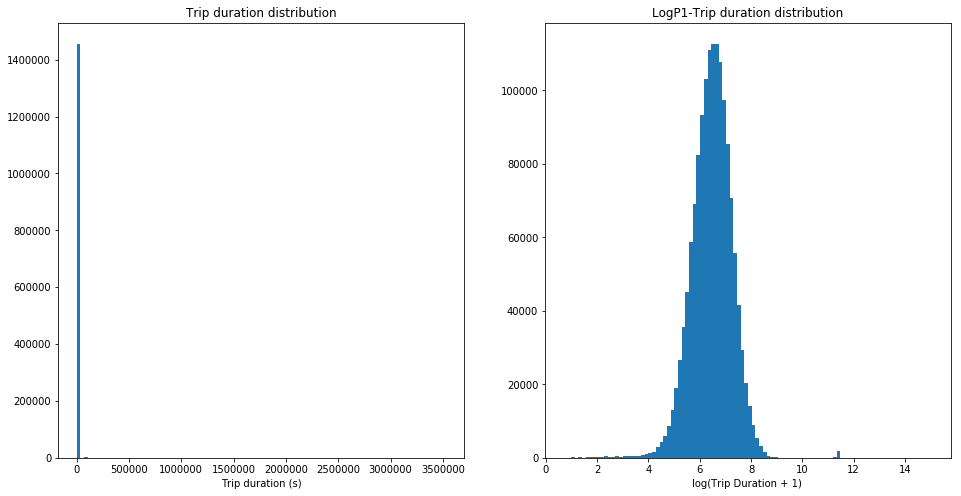

In [77]:
max_dur_hrs = np.max(train_raw["trip_duration"].values) / 3600
print(f'Max trip duration (hours): {max_dur_hrs:.3f}')

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8), sharex=False)

ax0.set_title('Trip duration distribution')
ax0.set_xlabel('Trip duration (s)')

ax1.set_title('LogP1-Trip duration distribution')
ax1.set_xlabel('log(Trip Duration + 1) ')

ax0.hist(train_raw['trip_duration'], bins=100);
ax1.hist(np.log1p(train_raw['trip_duration']), bins=100);

The target variable seems to follow a log-normal distribution, and there are definitely some potential outliers - the max trip duration is almost 1000 hours. Therefore we apply `numpy`'s `log1p` function on the values to obtain a more normal-like distribution.

This is an important step to note! If, down the line, we perform training and validation on the log-transformed values for the `trip_duration`, our training metric can be `RMSE` (root mean squared error). Then for our submission, we can simply "untransform" the predictions by using `np.expm1(predictions)` in order to conform with the competition training metric, `RMSLE` (root mean squared logarithmic error).

#### *Small programming aside*

Here I define some useful functions for keeping track of key points in the model-creation pipeline. There is probably a better way to do this, but this works fine for me.

I keep a dictionary called `checkpoints` which contains `(str, dict)` key-value pairs. The dictionary values are copies of my train and test sets. I also create a method called `add_checkpoint(key)` which will store the current state of my train and test sets in the dictionary. This way, if I ever make a mistake and need to revert back to a particular preprocessing step, I can call `get_checkpoint(key)` without having to scroll up and down, re-executing cells.

In [6]:
train_set = train_raw.copy(deep=True).drop('dropoff_datetime', axis=1)
test_set = test_raw.copy(deep=True)

In [7]:
checkpoints = {
    'pre_engineering': {
        'train': train_set.copy(deep=True),
        'test': test_set.copy(deep=True)
    }
}

In [8]:
def add_checkpoint(key):
    d = { 'train': train_set.copy(deep=True), 'test': test_set.copy(deep=True) }
    checkpoints.update({
        key: d
    })

In [9]:
def restore_checkpoint(key):
    return checkpoints[key]['train'].copy(deep=True), checkpoints[key]['test'].copy(deep=True)

<a id="catdata"></a>
### Categorical data

After further investigation, it seems we have some categorical columns - `vendor_id` and `store_and_fwd_flag`. Because we are going to be using `XGBoost` as one of our models, we need to ensure that these data columns are represented numerically. This is a common step in most tree-based approaches (i.e. Random Forests, Decision Trees, etc.). Pandas has a nice feature which allows us to integer-encode categorical variables:

    df := pd.DataFrame
    df[column] = df[column].astype('category').cat.codes
    
In our case, we technically don't even need to use this feature - the encoding is very simple. For example, for the `store_and_fwd_flag` column,

    df['store_and_fwd_flag'] = (df['store_and_fwd_flag'] == 'Y').astype(np.int32)
    
Either way, we will use the Pandas approach.

**NOTE**: It is very important that you apply feature engineering steps to both the train set and test set simultaneously. A good way to accomplish this is by using functions to perform dataframe manipulation, and passing the train and test set frames as arguments.

In [79]:
def cat_encode(*dfs):
    for df in dfs:
        for col in df.select_dtypes('object').columns:
            df[col] = df[col].astype('category').cat.codes

In [12]:
cat_encode(train_set, test_set)

<a id="dtdata"></a>
### `datetime` data 

Our train and test sets have a `pickup_datetime` column, which is of type `datetime64`. Pandas has some excellent functionality for extracting useful date-time information.

In the context of our problem, we should begin to think about what time-related features could affect the trip duration of a taxi ride. I think anyone that's been to NYC knows traffic is a nightmare at any time of the day, but it's especially true during rush-hour. I'd like to take a look at how the trip durations in the train set vary with different parts of the `pickup_datetime` - namely the month, the hour and minute of the day, and the day of the week.

We can extract that information using,

    df[datetime_col].dt.month
    df[datetime_col].dt.hour
    df[datetime_col].dt.minute
    df[datetime_col].dt.dayofweek
    
We'll concatenate that information as new columns in the train and test frames.

In [10]:
def extract_date_columns(*dfs):
    for df in dfs:
        df['pickup_datetime_month'] = df.pickup_datetime.dt.month
        df['pickup_datetime_hour'] = df.pickup_datetime.dt.hour
        df['pickup_datetime_minute'] = df.pickup_datetime.dt.minute
        df['pickup_datetime_dow'] = df.pickup_datetime.dt.dayofweek

In [13]:
extract_date_columns(train_set, test_set)

<a id="distance"></a>
### Calculating trip distance

All traffic ideas aside, imagining that NYC was completely empty except for one taxi cab, the most obvious influencing factor on trip duration would be trip distance.

We're given the pickup and dropoff `(latitude, longitude)` information, which means that we can approximate the total distance of the trip. The most straightforward way to do so would be to calculate the [Haversine Distance](#https://www.movable-type.co.uk/scripts/latlong.html) between the pickup point and dropoff point.

The Haversine distance is defined as "the distance a crow flies" between two geographic coordinates. However, taxis don't fly - especially not in Manhattan. In Manhattan, they drive on a grid. For trips that leave or enter Manhattan, the Haversine distance is perfectly fine. However, for inter-Manhattan trips, another Kaggle user found an interesting way to approximate a more Manhattan-like distance using the Haversine distance formula,

$D_{HM}(\phi_A, \theta_A, \phi_B, \theta_B) = D_H(\phi_A, \theta_A, \phi_A, \theta_B) + D_H(\phi_A, \theta_A, \phi_B, \theta_A)$

where $\phi_A$ and $\phi_B$ are the latitudes of points A and B respectively, $\theta_A$ and $\theta_B$ are the longitudes of points A and B respectively, $D_H$ is the normal Haversine Distance, and $D_{HM}$ is the Manhattan-like distance.

In [11]:
def _haversine_distance(lat_a, long_a, lat_b, long_b):
    '''Calculates the haversine distance between two geographic coordinates in meters.
    
    The haversine distance is defined as "the distance a crow flies" between two points.
    
    Parameters
    ----------
        lat_a  : latitude of point A (array-like)
        long_a : longitude of point A (array-like)
        lat_b  : latitude of point B  (array-like)
        long_b : longitude of point B (array-like)
    
    Returns
    -------
        the haversine distance between the two points
    '''
    del_lat_rad = lat_b - lat_a
    del_long_rad = long_b - long_a
    
    lat_a, long_a, lat_b, long_b, del_lat_rad, del_long_rad = \
        map(np.radians, [lat_a, long_a, lat_b, long_b, del_lat_rad, del_long_rad])
    
    def _a(del_lat, del_long, lat_a, lat_b):
        return (
            (np.sin(del_lat / 2) ** 2) +
            (np.cos(lat_a) * np.cos(lat_b) *
             np.sin(del_long / 2) ** 2)
        )
    
    
    def _c(a):
        return 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a));
    
    # radius of the earth in meters
    R = 6371e3
    
    a = _a(del_lat_rad, del_long_rad, lat_a, lat_b)
    c = _c(a)
    
    return R * c

def add_manhattan_haversine_distance(*dfs):
    '''Calculates the "true" Manhattan distance between two geographic coordinates.
    
    This is probably a bad estimation of a city-block distance, but is better than nothing.
    
    Parameters
    ----------
        dfs : dataframes in which to add the manhattan-haversine distance column
    '''
    for df in dfs:
        inbounds = df.loc[(df['pickup_longitude'] <= -73.94) & 
                           df['dropoff_longitude'] <= -73.94]

        inbounds_idx = inbounds.index

        oob = df.loc[~df.index.isin(inbounds_idx), :]
        oob_idx = oob.index

        ib_lat_a = inbounds['pickup_latitude']
        ib_lat_b = inbounds['dropoff_latitude']
        ib_long_a = inbounds['pickup_longitude']
        ib_long_b = inbounds['dropoff_longitude']

        oob_lat_a = oob['pickup_latitude']
        oob_lat_b = oob['dropoff_latitude']
        oob_long_a = oob['pickup_longitude']
        oob_long_b = oob['dropoff_longitude']

        df['city_distance'] = pd.Series(np.zeros(shape=(len(df.index))), index=df.index)
        df.loc[inbounds_idx, 'city_distance'] = _haversine_distance(ib_lat_a, ib_long_a, 
                                                                    ib_lat_a, ib_long_b) + \
                                                _haversine_distance(ib_lat_a, ib_long_a, 
                                                                    ib_lat_b, ib_long_a)
        df.loc[oob_idx, 'city_distance'] = _haversine_distance(oob_lat_a, oob_long_a, 
                                                               oob_lat_b, oob_long_b)



In [14]:
add_manhattan_haversine_distance(train_set, test_set)

In [15]:
add_checkpoint('with_manhattan')

When we take a look at the trip distances, it seems that we again have some outliers. Applying the same log transform (`np.log1p`) to the trip distances gives us a better look at their distributions.

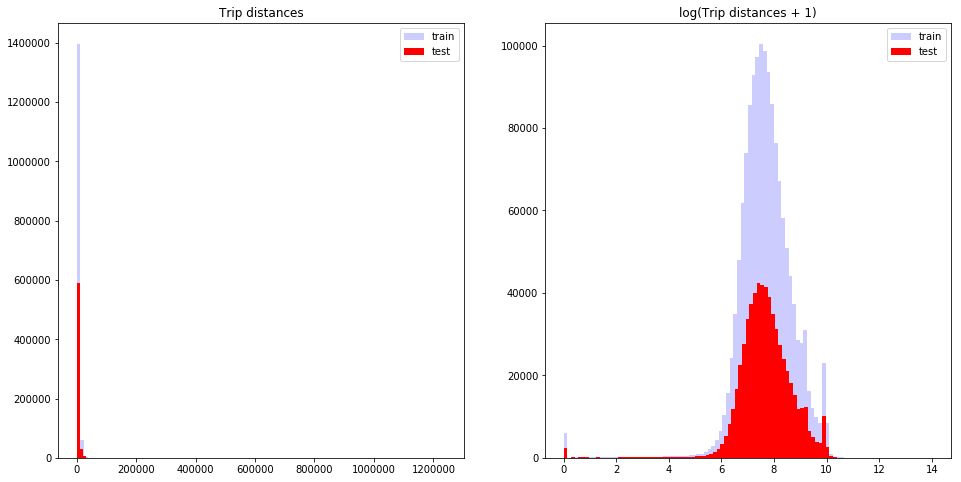

In [16]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

ax0.set_title('Trip distances')

ax1.set_title('log(Trip distances + 1)')

ax0.hist(train_set['city_distance'], color='blue', alpha=0.2, bins=100, label='train')
ax0.hist(test_set['city_distance'], color='red', bins=100, label='test')
ax1.hist(np.log1p(train_set['city_distance']), color='blue', 
         alpha=0.2, bins=100, label='train')
ax1.hist(np.log1p(test_set['city_distance']), 
         color='red',  bins=100, label='test')

ax0.legend()
ax1.legend();

It seems our train and test sets follow quite similar distributions, which is very nice.

<a id="featcor"></a>
### Feature correlation

Now that we have done some feature engineering, let's see if we find any correlation between our selected features and the target variable.

In [17]:
corr = train_set.corr()

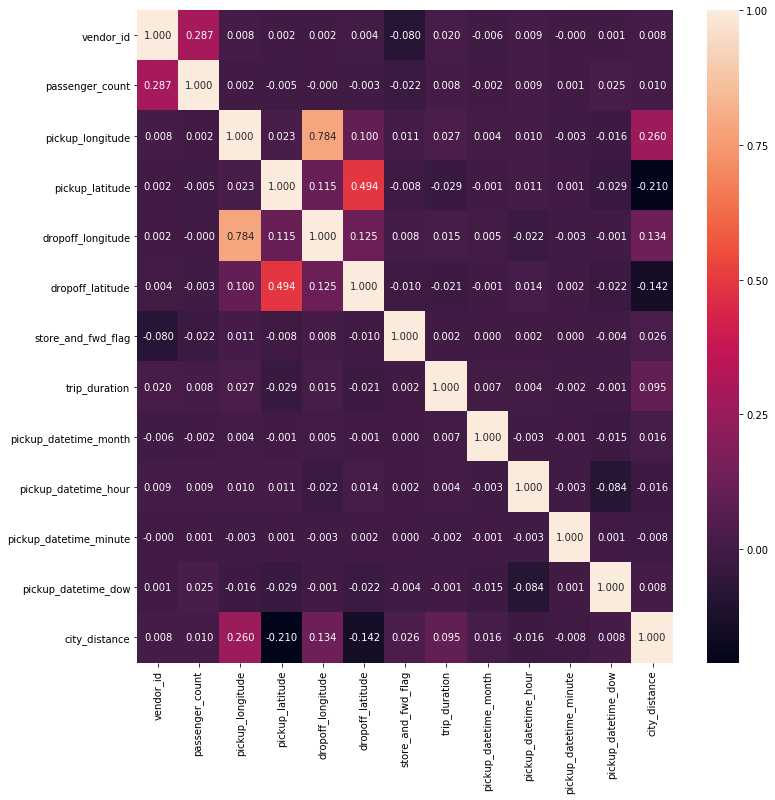

In [18]:
_, ax = plt.subplots(1, figsize=(12, 12))

ax.xaxis.set_ticklabels([c for c in corr.columns.values], rotation=45)
ax.yaxis.set_ticklabels([c for c in corr.columns.values], rotation=0)

sns.heatmap(corr, annot=True, ax=ax, fmt='.3f');

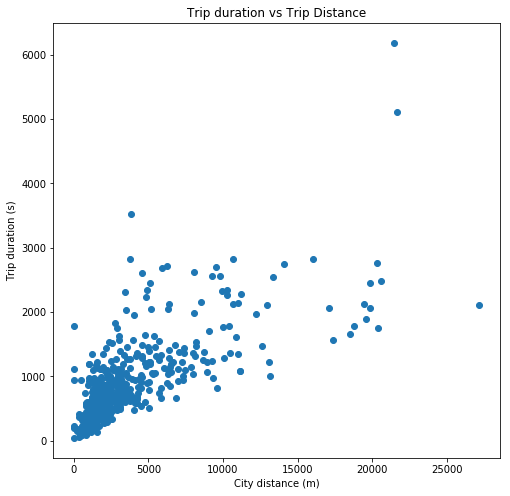

In [19]:
_, ax = plt.subplots(1, figsize=(8, 8))
ax.set_title('Trip duration vs Trip Distance')
ax.set_xlabel('City distance (m)')
ax.set_ylabel('Trip duration (s)')
ax.scatter(train_set['city_distance'][:500], train_set['trip_duration'][:500]);

Perhaps most obviously, it seems that `city_distance` is the feature which is most correlated with trip duration - seems logical. However, I'm quite surprised to see that the date information we extracted doesn't correlate very strongly.

Granted, this does represent the Pearsman correlation, which assumes linear correlation. If we wanted to perhaps get a better picture, we could calculate the Spearman correlations. Let's do some more visualization of the date information versus trip duration.

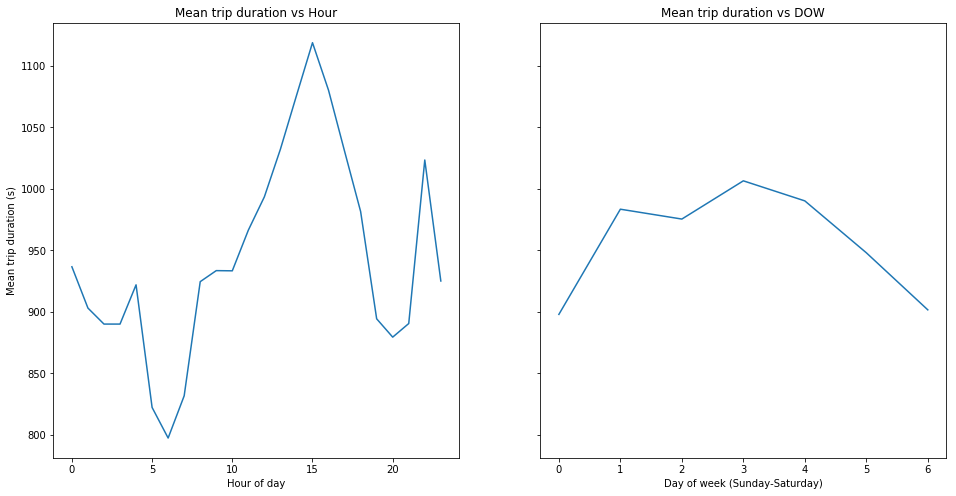

In [20]:
h = train_set.groupby('pickup_datetime_hour').mean()['trip_duration']
dow = train_set.groupby('pickup_datetime_dow').mean()['trip_duration']
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
ax0.plot(h.index.values, h.values)
ax0.set_title('Mean trip duration vs Hour')
ax0.set_ylabel('Mean trip duration (s)');
ax0.set_xlabel('Hour of day')

ax1.plot(dow.index.values, dow.values)
ax1.set_title('Mean trip duration vs DOW')
ax1.set_xlabel('Day of week (Sunday-Saturday)');


As expected, right around 3PM there's a spike in mean trip duration. This probably corresponds to the beginning of rush-hour traffic, which lasts until around 6 or 7PM.

In terms of the day of week, there seems to be slightly increased mean trip duration times - probably the lethargy of stressful NYC work-life kicking in right around hump day (Wednesday/Thursday).

These two plots, despite the correlation heatmap, make me believe that the datetime information we extracted is going to be useful in the modeling phase.

<a id="clustering"></a>
### Geospatial Clustering

Plotting latitude vs longitude for both pickup and dropoff locations in the train and test sets yields some interesting (and frankly quite beautiful) information. We can see that the dropoff locations are more varied than the pickup locations, indicating that people typically take taxi rides out of Manhattan to differnt points of interest outside of the city limits. For example, the little concentrated cluster on the bottom right of the plot is JFK International Airport.

Furthermore, a good thing to note is that the trian set and test sets seem to cover the same areas.

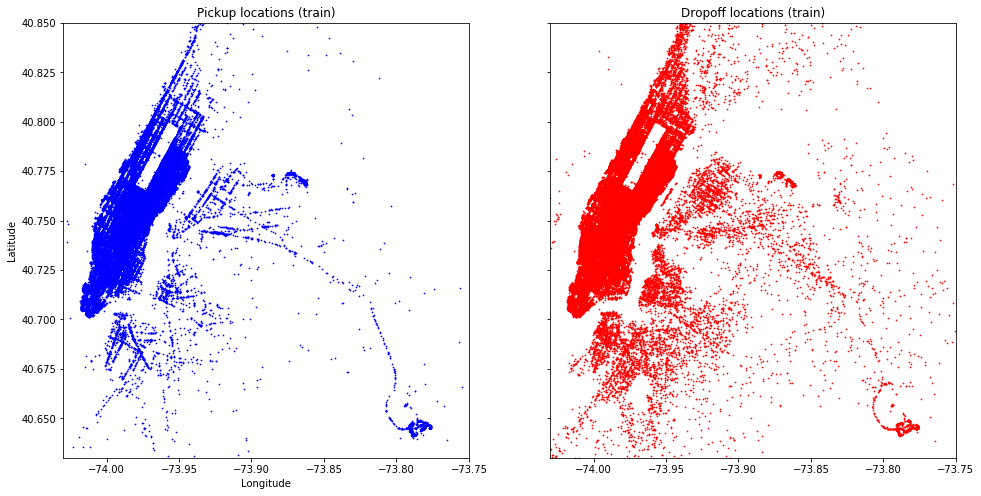

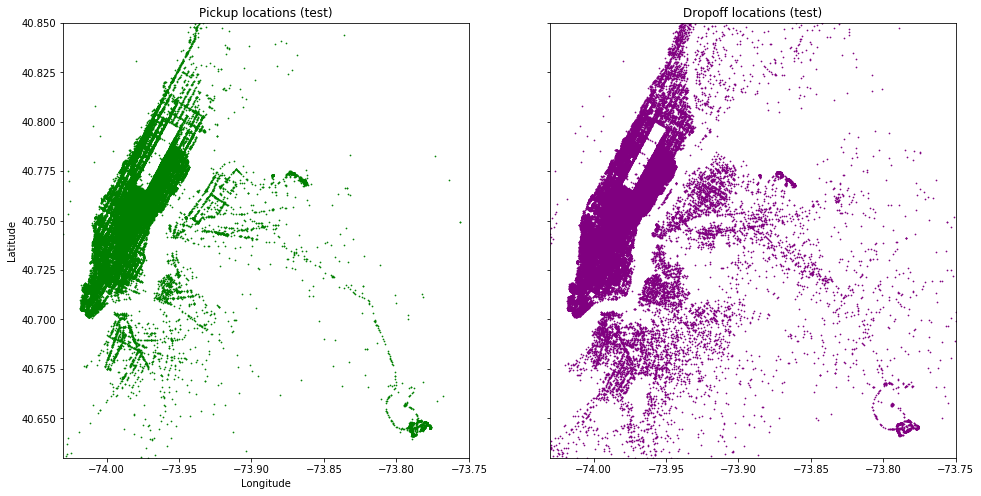

In [21]:
island_long_border = (-74.03, -73.75)
island_lat_border = (40.63, 40.85)

pickup_lat_train = train_set.pickup_latitude[:100000]
pickup_long_train = train_set.pickup_longitude[:100000]

dropoff_lat_train = train_set.dropoff_latitude[:100000]
dropoff_long_train = train_set.dropoff_longitude[:100000]

pickup_lat_test = test_set.pickup_latitude[:100000]
pickup_long_test = test_set.pickup_longitude[:100000]

dropoff_lat_test = test_set.dropoff_latitude[:100000]
dropoff_long_test = test_set.dropoff_longitude[:100000]

_fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
ax0.set_xlim(island_long_border)
ax0.set_ylim(island_lat_border);
ax0.set_title('Pickup locations (train)')
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')
ax0.scatter(pickup_long_train, pickup_lat_train, c='blue', s=0.5)
ax1.scatter(dropoff_long_train, dropoff_lat_train, c='red', s=0.5)
ax1.set_title('Dropoff locations (train)')

_fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
ax0.set_xlim(island_long_border)
ax0.set_ylim(island_lat_border);
ax0.set_title('Pickup locations (test)')
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')
ax0.scatter(pickup_long_test, pickup_lat_test, c='green', s=0.5)
ax1.scatter(dropoff_long_test, dropoff_lat_test, c='purple', s=0.5);
ax1.set_title('Dropoff locations (test)');

Very often latitude and longitude alone are not the strongest predictors (features), so doing some feature engineering to enrich their prediction strength is advised.

We can use `MiniBatchKMeans` to do some zone clustering, and add the clustering results as categorical features, i.e. assign the pickup and dropoff locations to cluster. As we have already determined, the dropoff locations represent a larger variety of locations, so we will train the clustering model using the train set dropoff latitude and longitude coordinates.

In [23]:
%%time
cluster_set = train_set.loc[:, ['dropoff_latitude', 'dropoff_longitude']]

k = 50
mbkmeans = MiniBatchKMeans(n_clusters=k, batch_size=32)
mbkmeans.fit(cluster_set)
cluster_set['cluster'] = pd.Series(mbkmeans.labels_, index=cluster_set.index)

_, ax = plt.subplots(1, figsize=(12, 12))

island_long_border = (-74.03, -73.75)
island_lat_border = (40.63, 40.85)

lat = cluster_set.iloc[:100000, :]['dropoff_latitude']
lon = cluster_set.iloc[:100000, :]['dropoff_longitude']
clusters = cluster_set.iloc[:100000, :]['cluster']

ax.scatter(lon.values, lat.values, c=clusters, cmap='tab20c', alpha=0.5, s=1)
ax.set_xlim(island_long_border)
ax.set_ylim(island_lat_border);

train_set['dropoff_cluster'] = cluster_set['cluster']
test_set['dropoff_cluster'] = \
    pd.Series(mbkmeans.predict(test_set.loc[:, ['dropoff_latitude', 'dropoff_longitude']].values),
              index=test_set.index)

train_set['pickup_cluster'] = \
    pd.Series(mbkmeans.predict(train_set.loc[:, ['pickup_latitude', 'pickup_longitude']].values),
              index=train_set.index)
test_set['pickup_cluster'] = \
    pd.Series(mbkmeans.predict(test_set.loc[:, ['pickup_latitude', 'pickup_longitude']].values),
              index=test_set.index);

Wall time: 23.6 s


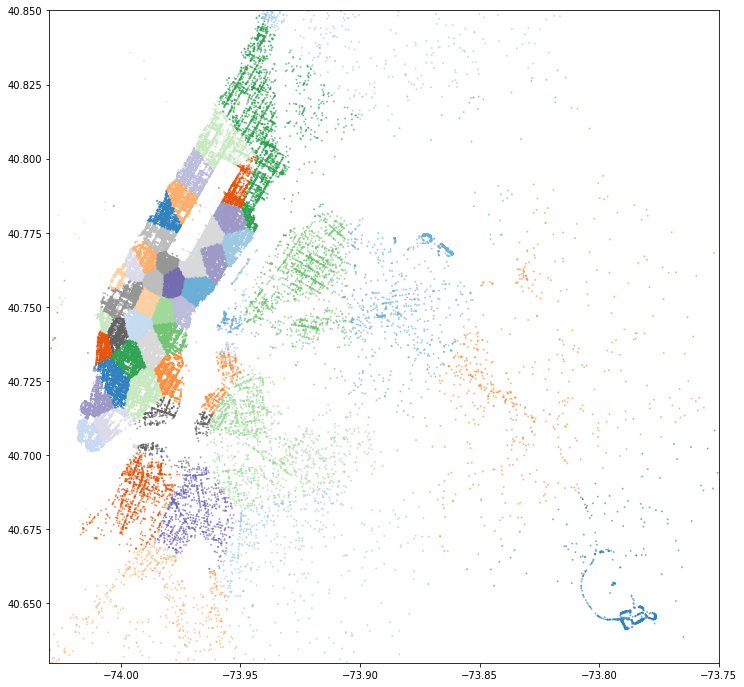

The clustering seems to be robust - and is very pretty to look at...

In [26]:
add_checkpoint('post_clustering')

## Modeling

Now that our exploratory analysis and feature engineering is complete, it's time to build some models. We're going to train and cross-validate two models - `XGBoost` and `CatBoost`.

The first step is to drop the no longer needed datetime columns, and separate the features and labels.

In [27]:
train_set.drop('pickup_datetime', axis=1, inplace=True)
test_set.drop('pickup_datetime', axis=1, inplace=True)
add_checkpoint('pre_modeling')

In [28]:
X = train_set.drop('trip_duration', axis=1)
y = np.log1p(train_set['trip_duration'])

In [29]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y)

### XGBoost

#### Cross-Validation, Random Parameter Search

For `XGBoost` we can use `scikit-learn`'s random parameter searching functionality to perform cross validation, and to find optimal model parameters. `RandomizedSearchCV` is compatible with all `scikit-learn` estimators, *and* XGBoost. The `xgboost` library has a `sklearn` module (`xgboost.sklearn`) which contains a `scikit-learn` based implementation of the algorithm. We will use this implementation for cross-validation, and we will use the standard `xgboost` implementation for training and prediction.

**NOTE**: In the interest of saving time in executing this notebook, I performed the parameter search and cross validation in a separate notebook, as it is quite a computationally expensive and time-consuming process. I'll supply a code example on how you can use `RandomizedSearchCV` with `XGBRegressor` below.

```python
xgb_param_grid = {
    'n_estimators': [25, 100, 250],
    'learning_rate': np.linspace(0.1, 0.3, num=5),
    'subsample': np.linspace(0.3, 0.7, num=5),
    'max_depth': [3, 6, 10],
    'colsample_bytree': np.linspace(0.5, 0.75, num=3),
    'min_child_weight': [1, 10, 25, 75]
}

X_train, X_validate, y_train, y_validate = train_test_split(X, y)

xgb_regressor = xgb.XGBRegressor(objective='reg:linear', booster='gbtree')
xgb_random_search = RandomizedSearchCV(xgb_regressor, 
                                       param_distributions=xgb_param_grid, 
                                       n_iter=25, scoring='neg_mean_squared_error',
                                       error_score=0, verbose=3, n_jobs=-1, cv=5)
xgb_random_search.fit(X_train, y_train)
v_preds = xgb_random_search.predict(X_validate)
print(f'RMSE on validation set: {np.sqrt(mean_squared_error(y_validate, v_preds))}')
```

#### Training

Now that we've found the optimal model parameters, let's train the model!

Remember, when using `xgboost`, you need to first wrap your training, validation, and test sets in a `xgb.DMatrix`.

In [34]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_validate = xgb.DMatrix(X_validate, label=y_validate)

evallist = [(xgb_train, 'training-set'), (xgb_validate, 'validation-set')]

xgb_params = {
    'n_estimators': 250,
    'eta': 0.2,
    'subsample': 0.6,
    'max_depth': 10,
    'colsample_bytree': 0.75,
    'min_child_weight': 25,
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'nthread': -1,
    'silent': 1,
    'eval_metric': 'rmse'
}

In [35]:
if DO_XGBOOST:
    xgb_regressor = xgb.train(xgb_params, xgb_train, 100, evallist,
                              early_stopping_rounds=100, maximize=False,
                              verbose_eval=10)

[0]	training-set-rmse:4.82435	validation-set-rmse:4.82486
Multiple eval metrics have been passed: 'validation-set-rmse' will be used for early stopping.

Will train until validation-set-rmse hasn't improved in 100 rounds.
[10]	training-set-rmse:0.674673	validation-set-rmse:0.677591
[20]	training-set-rmse:0.414683	validation-set-rmse:0.422574
[30]	training-set-rmse:0.401304	validation-set-rmse:0.41184
[40]	training-set-rmse:0.396193	validation-set-rmse:0.40931
[50]	training-set-rmse:0.392279	validation-set-rmse:0.407221
[60]	training-set-rmse:0.38951	validation-set-rmse:0.4063
[70]	training-set-rmse:0.387483	validation-set-rmse:0.406259
[80]	training-set-rmse:0.385549	validation-set-rmse:0.405515
[90]	training-set-rmse:0.383736	validation-set-rmse:0.405082
[99]	training-set-rmse:0.382326	validation-set-rmse:0.404647


We've broken the .4 barrier on the training set, and have come pretty close on the validation set. Let's see if `CatBoost` can do any better.

### CatBoost

`CatBoost` is another tree-based boosting algorithm which works well with categorical variables. It is has a 4x time-performance when compared to `XGBoost` on large datasets, and a 2x time-performance on small-medium datasets. Because we have a few categorical variables in our data, it might be interesting to see if we can obtain any performance gains when compared to `XGBoost`.

#### Cross-Validation

Again, in the interest of saving time, I have simply supplied the code I used to cross-validate the `CatBoost` model below. Note that `CatBoost` does not have a `scikit-learn` estimator-based interface, so you must rely on their cross-validation module (`catboost.cv`).

```python
cat_features = [0, 6, 12, 13]
cat_cv_pool = Pool(X, label=y, cat_features=cat_features)
cat_cv_params = {
    'loss_function': 'RMSE',
    'iterations': 250,
    'learning_rate': 0.2,
    'random_seed': 42,
    'depth': 10
}
cv = catboost_cv(pool=cat_cv_pool, params=cat_cv_params, fold_count=5)
print(cv)
```

#### Training

In [ ]:
cat_features = [0, 6, 12, 13]
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
validation_pool = Pool(X_validate, label=y_validate, cat_features=cat_features)
cat_regressor = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    iterations=250,
    learning_rate=0.2,
    depth=10
)

Unforunately the training process is quite verbose with `CatBoost`, so apologies for the scrolling.

We see that `CatBoost` peforms quite similarly to `XGBoost`, again coming quite close to breaking the .4 barrier on the validation set. The only thing left to do is to predict on the test set using our models and submit our work.

In [57]:
if DO_CATBOOST:
    cat_regressor.fit(train_pool, eval_set=validation_pool)

0:	learn: 5.2239927	test: 5.2243481	best: 5.2243481 (0)	total: 2.54s	remaining: 10m 33s
1:	learn: 4.1927069	test: 4.1931882	best: 4.1931882 (1)	total: 4.97s	remaining: 10m 17s
2:	learn: 3.3689179	test: 3.3695298	best: 3.3695298 (2)	total: 6.56s	remaining: 8m 59s
3:	learn: 2.7120844	test: 2.7127975	best: 2.7127975 (3)	total: 9.13s	remaining: 9m 21s
4:	learn: 2.1893572	test: 2.1901271	best: 2.1901271 (4)	total: 11.7s	remaining: 9m 33s
5:	learn: 1.7764777	test: 1.7772967	best: 1.7772967 (5)	total: 14s	remaining: 9m 30s
6:	learn: 1.4507667	test: 1.4516034	best: 1.4516034 (6)	total: 15.8s	remaining: 9m 8s
7:	learn: 1.1955620	test: 1.1963752	best: 1.1963752 (7)	total: 18.1s	remaining: 9m 8s
8:	learn: 0.9978872	test: 0.9987214	best: 0.9987214 (8)	total: 20.5s	remaining: 9m 8s
9:	learn: 0.8466119	test: 0.8475105	best: 0.8475105 (9)	total: 22.9s	remaining: 9m 10s
10:	learn: 0.7319550	test: 0.7329722	best: 0.7329722 (10)	total: 25.9s	remaining: 9m 22s
11:	learn: 0.6475567	test: 0.6486426	best: 0

92:	learn: 0.4083849	test: 0.4162689	best: 0.4162689 (92)	total: 3m 35s	remaining: 6m 3s
93:	learn: 0.4081415	test: 0.4160992	best: 0.4160992 (93)	total: 3m 37s	remaining: 6m
94:	learn: 0.4078995	test: 0.4158995	best: 0.4158995 (94)	total: 3m 39s	remaining: 5m 58s
95:	learn: 0.4076664	test: 0.4158014	best: 0.4158014 (95)	total: 3m 42s	remaining: 5m 56s
96:	learn: 0.4074521	test: 0.4156593	best: 0.4156593 (96)	total: 3m 44s	remaining: 5m 54s
97:	learn: 0.4073808	test: 0.4156262	best: 0.4156262 (97)	total: 3m 47s	remaining: 5m 52s
98:	learn: 0.4071712	test: 0.4155578	best: 0.4155578 (98)	total: 3m 49s	remaining: 5m 49s
99:	learn: 0.4069315	test: 0.4155105	best: 0.4155105 (99)	total: 3m 51s	remaining: 5m 47s
100:	learn: 0.4065887	test: 0.4153692	best: 0.4153692 (100)	total: 3m 53s	remaining: 5m 45s
101:	learn: 0.4064861	test: 0.4153093	best: 0.4153093 (101)	total: 3m 56s	remaining: 5m 42s
102:	learn: 0.4063276	test: 0.4152337	best: 0.4152337 (102)	total: 3m 58s	remaining: 5m 40s
103:	lear

182:	learn: 0.3941477	test: 0.4110533	best: 0.4110533 (182)	total: 7m 7s	remaining: 2m 36s
183:	learn: 0.3940855	test: 0.4110419	best: 0.4110419 (183)	total: 7m 9s	remaining: 2m 33s
184:	learn: 0.3939132	test: 0.4109392	best: 0.4109392 (184)	total: 7m 11s	remaining: 2m 31s
185:	learn: 0.3937572	test: 0.4109002	best: 0.4109002 (185)	total: 7m 13s	remaining: 2m 29s
186:	learn: 0.3937054	test: 0.4108994	best: 0.4108994 (186)	total: 7m 16s	remaining: 2m 26s
187:	learn: 0.3935796	test: 0.4109353	best: 0.4108994 (186)	total: 7m 18s	remaining: 2m 24s
188:	learn: 0.3934458	test: 0.4109560	best: 0.4108994 (186)	total: 7m 20s	remaining: 2m 22s
189:	learn: 0.3933368	test: 0.4108690	best: 0.4108690 (189)	total: 7m 23s	remaining: 2m 19s
190:	learn: 0.3931698	test: 0.4107549	best: 0.4107549 (190)	total: 7m 25s	remaining: 2m 17s
191:	learn: 0.3930495	test: 0.4107654	best: 0.4107549 (190)	total: 7m 27s	remaining: 2m 15s
192:	learn: 0.3928640	test: 0.4107075	best: 0.4107075 (192)	total: 7m 29s	remainin

## Submission

In [63]:
def create_xgb_submission():
    preds = xgb_regressor.predict(xgb.DMatrix(test_set))
    preds_df = pd.DataFrame(np.expm1(preds), index=test_set.index)
    preds_df.columns = ['trip_duration']
    
    preds_df.to_csv('submission.csv')
    display(pd.read_csv('submission.csv').head())
    
def create_catboost_submission():
    pool = Pool(test_set, cat_features=cat_features)
    preds = cat_regressor.predict(pool)
    preds_df = pd.DataFrame(np.expm1(preds), index=test_set.index)
    preds_df.columns = ['trip_duration']
    
    preds_df.to_csv('submission.csv')
    display(pd.read_csv('submission.csv').head())

if DO_XGBOOST:
    create_xgb_submission()
if DO_CATBOOST:
    create_catboost_submission()

,id,trip_duration
0,id3004672,865.781805
1,id3505355,591.526857
2,id1217141,433.221516
3,id2150126,959.964740
4,id1598245,357.657142


The results are in! Unforunately we didn't break .4 on the test set, but we came quite close.

`XGBoost`
![XGBoost](./results/xgboost_score.png)
`CatBoost`
![CatBoost](./results/catboost_score.png)


## Discussion

We've tested two models, `XGBoost` (RMSE: 0.41134) and `CatBoost` (RMSE: 0.41398), and both performed well on the test set. However, we couldn't quite get below an RMSE of 0.4.

In terms of CV and training times, `CatBoost` is the winner by a landslide. Cross validation took 1 hour and 41 minutes on the supplied parameter grid, and the model trained in roughly 8 minutes. `XGBoost` with a randomized parameter grid search took 13 hours to cross-validate, and and trained in 12 minutes.

`XGBoost` managed to obtain a better RMSE score, but not by much. I will of course be submitting the `XGBoost` as a final model - after all, it's a competition. However, in real world situations, we as datascientists are often faced with the dilemma of building a highly cross-validated and performant model versus taking a slight performance hit in the interest of streamlining productivity. If this were a client project, and my team and I were pressed for time, I'd probably go with `CatBoost` as it performs quite well, and in much less time.

In terms of the scores themselves, I'm sure that further feature engineering could help improve the models. There exists a variety of datasets containing valuable information which could enrich the feature space, and those who wish to expand upon the work we've done here are encouraged to investigate and contribute.

I hope that this notebook was helpful and interesting.